# IMport

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import unicodedata

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

from torch.nn import CrossEntropyLoss

from torch.utils.data import Dataset, DataLoader



# Read Data

In [2]:
df = pd.read_csv("sentiment_data.tsv", sep="\t")

# EDA

In [3]:
df.head(5)

,ID,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         241145 non-null  int64 
 1   Comment    240928 non-null  object
 2   Sentiment  241145 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


In [5]:
df.isnull().sum()

,0
ID,0
Comment,217
Sentiment,0


In [6]:
df[df['Comment'].isnull()]

,ID,Comment,Sentiment
1014,1017,NaN,1
4732,4748,NaN,1
7414,7437,NaN,2
7431,7454,NaN,1
7496,7519,NaN,1
...,...,...,...
223441,224219,NaN,1
228310,229088,NaN,2
233352,234130,NaN,1
235494,236272,NaN,1


In [7]:
df = df.dropna(subset=['Comment'])

Terdapat nilai null sebanyak 217 (proporsi 217/241145 = 0.08%) Sangat sedikit sehingga bisa didrop saja

In [8]:
df.drop_duplicates(subset=['Comment'])

,ID,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2
...,...,...,...
241140,241921,crores paid neerav modi recovered congress lea...,0
241141,241922,dear rss terrorist payal gawar modi killing pl...,0
241142,241923,cover interaction forum left,1
241143,241924,big project came india modi dream project happ...,1


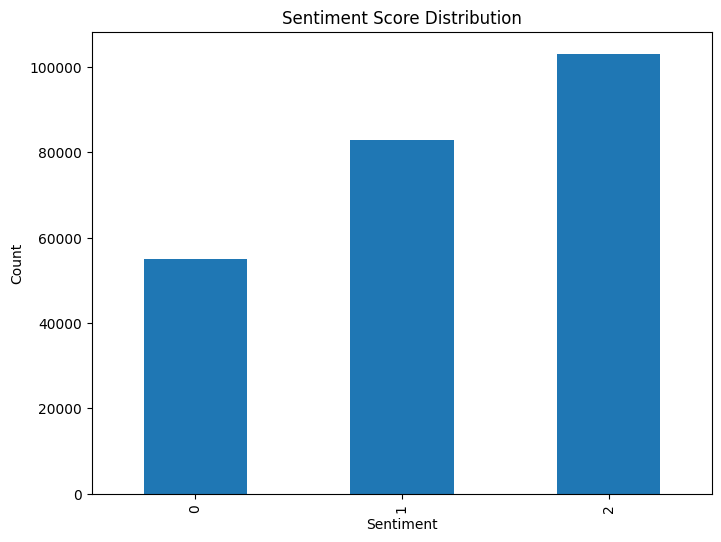

In [9]:
plt.figure(figsize=(8, 6))

df['Sentiment'].value_counts().sort_index().plot(kind='bar')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Score Distribution')
plt.show()

Dataset kolom sentimen menunjukan adanya ketidakseimbangan antar kelas

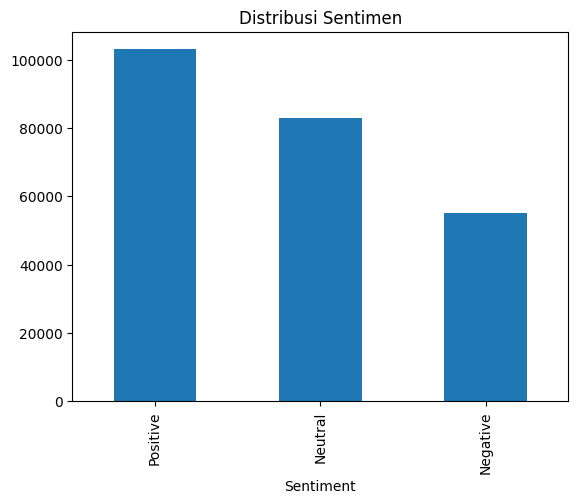

In [10]:
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['Sentiment'] = df['Sentiment'].map(sentiment_map)


df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Distribusi Sentimen')
plt.show()

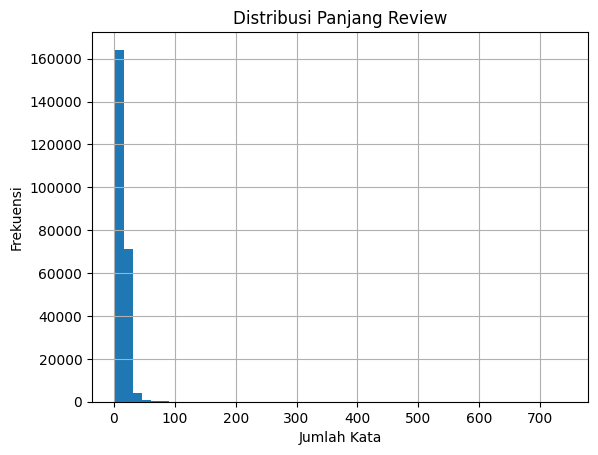

In [11]:
df['text_length'] = df['Comment'].apply(lambda x : len(x.split()))

df['text_length'].hist(bins=50)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Review')
plt.show()

In [12]:
df[df['text_length'] < 3].shape

(10129, 4)

In [13]:
df[df['text_length'] < 3].head(5)

,ID,Comment,Sentiment,text_length
167,167,cool,Positive,1
168,168,nice love,Positive,2
278,278,awesome,Positive,1
648,649,making struggling,Negative,2
654,655,bihar ba,Neutral,2


Pada kasus ini, teks singkat pada  masih bisa dianalisis sentimennya dan jumlahnya juga lumayan banyak. jadi jangan didrop

In [14]:
df['text_length'].describe()

,text_length
count,240928.000000
mean,13.004694
std,10.224321
min,1.000000
25%,6.000000
50%,11.000000
75%,18.000000
max,742.000000


Disini akan dipakai max_len = 128 karena sudah mencakup keseluruhan data (mean=13 dan median=11)

In [15]:
df[df['text_length'] > 128].shape

(120, 4)

Ada terdapat teks dengan panjang > 128. Hal ini perlu ditangani

In [16]:
pd.set_option('display.max_colwidth', None)

In [17]:
df[df['text_length'] > 128][['Comment']].head(5)


,Comment
186,yup amazing though market changes brands country germany entirely different line knockoff chinese brands ultimately look alike goes australian american market kinda stoked see though sort dashcams actually used within south korea japan anybody could give hint mean surely must great dashcams right japan leading technology country severe amount car enthusiasts well south korea well main birth place technology centre fab well least good portion mind bought one due recommendation friend mine problem quality related gsensor broke long bought thing started using kinda unfortunate creates issue thing constantly making emergency recordings mode cant disable screen flashing night drives youll really get beamed faze think someone put flashlight head nope f dashcam improve video quality eg experincing intense sun glare usually caused using ndfilter find way mount usually full filter clamping solutions youll overshoot filter anyhow didnt yet find nessecary big german dashcam clip compilation maker recommend one dashcam review videos half year ago name channel eure videos fahrnünftig german amazon thieye american market jansite nexigo australian nz market volway
277,im channel products feature videos kickstarter honestly point change name kick starter never starter lol im saying im also laughing butt hella funny also hella true yes also hella shady well sorry couldnt help anyway back point trust really good point case youre still laughing let get back track like said products featured channel sister channel products kickstarter products kickstarter never even make market thats right read correct numbers correct research basically channel future tech sister channel future channels useless products show never ever able purchase basically honestly waste everybodys youtube time unless like looking videos feature products gadgets never come market never able purchase seriously funny sarcastic also serious honestly im im channel thats unsubscribe im telling everybody else unsubscribe unsubscribed please everybody unsubscribe point time future tech future channels display products kickstarter keyword display basically products prototypes display public never able buy never come market oh kickstarter oops im sorry mean never starter oh god im sorry couldnt help still funny lol like said products never end going market never end sold whole useless channel waste time time everybody elses time okay guess times goodbye remember everybody please big favor unsubscribe
502,something important know interested history andor support ukraine rus’ ought confused “russia” derives name rus’ historically completely different state almost existence war rus’ like holy roman empire actually germany russia actually muscovy despite best attempts convince everybody otherwise name “russia received peter passed decree change tsardom muscovy’s name “russian” empire “russia” originates rosia name used greek orthodox clergy regards kyivan rus reign cathrine ii muscovites even punished continuing identify muscovites forced call “russian” lands “russia” claims part original rus’ actually werent novgorod suzdal ryazan since historical texts xixii centuries mentioned separate entities rus’ considered parts extended rus’ although culture distinct main rus’ moscow prince ivan iii appointed great ruler rus’ kings acknowledged point muscovy started make false claims rus’ ownership “russia” offshoot ukraine way round despite soviet “russian” historians trying say years kiev developed cultured capital moscow another swamp village germany used call holy roman empire didn’t mean became romans sudden right claim whole italy history yet that’s exactly “russia” regards rus’ukraine horrible injustice
952,artistic music mix top songs ♫ best ncs gaming music ♫ best edm remixes tks listening tracklist beauz memories official audio ft linney streamdownload king caan go feat elysa diviners azertion feelings ncs release redmoon meron ryan heavyweight ncs release voster gallardo x v

Setelah analisis lebih dalam ternyata terdapat :

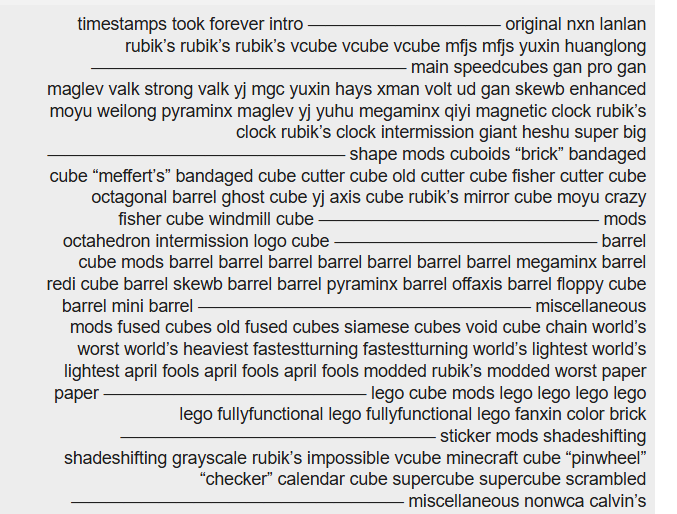

Pada gambar di atas, ditemukan bahwa ada teks yang mengandung spam dengan banyak repetisi kata dan hampir tidak dapat dilihat sentimentnya. Ini perlu didrop

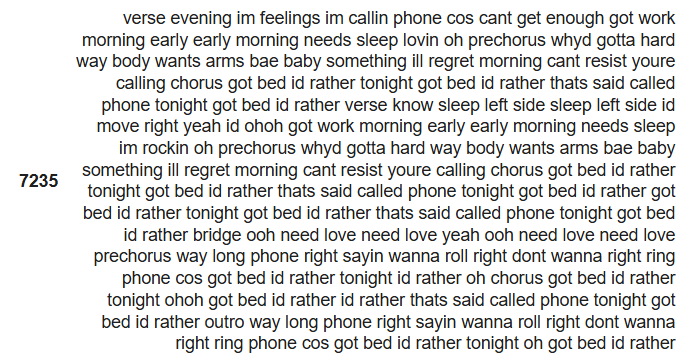

Pada gambar di atas, ini adalah contoh spam lainnya yaitu berbentuk lirik lagu. Kalau kita lihat sentimen nya sulit dideteksi, lebih baik didrop saja karena bisa menjadi noise

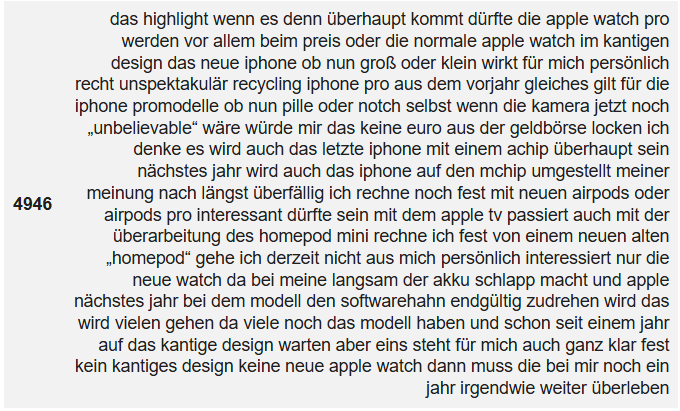

Pada gambar di atas, ditemukan juga data teks yang bukan bahasa inggris. Untuk masalah teks yang non-inggris akan ditangani ke depannya

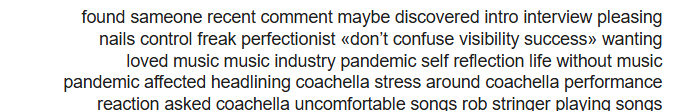

Pada gambar di atas, terdapat kata typo sameone yang seharusnya someone. Ini masih bisa dibiarkan karena typo itu normal di nlp

In [18]:
def is_keyword_spam(text):
    tokens = text.split()
    if len(tokens) < 50:
        return False
    unique_ratio = len(set(tokens)) / len(tokens)
    return unique_ratio < 0.6

In [19]:
df['is_spam'] = df['Comment'].apply(is_keyword_spam)


In [20]:
df['is_spam'].value_counts()

,count
is_spam,
False,240889
True,39


In [21]:
df[df['is_spam']].head(5)[['Comment']]

,Comment
277,im channel products feature videos kickstarter honestly point change name kick starter never starter lol im saying im also laughing butt hella funny also hella true yes also hella shady well sorry couldnt help anyway back point trust really good point case youre still laughing let get back track like said products featured channel sister channel products kickstarter products kickstarter never even make market thats right read correct numbers correct research basically channel future tech sister channel future channels useless products show never ever able purchase basically honestly waste everybodys youtube time unless like looking videos feature products gadgets never come market never able purchase seriously funny sarcastic also serious honestly im im channel thats unsubscribe im telling everybody else unsubscribe unsubscribed please everybody unsubscribe point time future tech future channels display products kickstarter keyword display basically products prototypes display public never able buy never come market oh kickstarter oops im sorry mean never starter oh god im sorry couldnt help still funny lol like said products never end going market never end sold whole useless channel waste time time everybody elses time okay guess times goodbye remember everybody please big favor unsubscribe
912,khuyến mãi tới các mẫu tai nghe chuyên game cực rẻ xem ngay tai nghe bluetooth không dây chuyên game tai nghe có mic rời lọc âm giá rẻ tai nghe siêu rẻ chuyên game free fire tai nghe nghe nhạc hay chơi game đỉnh tai nghe micro chuyên dụng chơi game tai nghe gpro cổng typec cao cấp chuyên game quạt tản nhiệt sò lạnh memo siêu mát quạt tản nhiệt điện thoại memo giá rẻ
2650,timestamps intro sign canva account homepage explained photoshop vs canva create new canva design ways canva editor top panel explained canva editor side panel explained using photos using elements canva editor side panel continued designing canva editor working text adding link additional functionalities canva editor download designs canva free vs canva pro canva pro brand kit canva pro content planner canva pro additional functionalities editor learn canva
2750,course helpful please leave like subscribe become kubernetes administrator cka become devops engineer complete devops bootcamp udemy courses useful links ► main kubectl commands cli git repo ► yaml configuration file git repo ► demo project git repo ► kubernetes ingress git repo ► kubernetes volumes git repo ▬▬▬▬▬▬ connect ▬▬▬▬▬▬ join private facebook group ► instagram ► twitter ► linkedin ► ▬▬▬▬▬▬ want learn ▬▬▬▬▬▬ devops tools like terraform prometheus ► jenkins pipeline tutorials ► kubernetes cloud ► ▬▬▬▬▬▬ courses ebooks bootcamp ▬▬▬▬▬▬ ► become devops engineer full educational program ► highquality handson courses ► kubernetes compact easytoread ebook bundle
3847,ledger ► limited time offer plus free shipping shop ► ledger ► limited time special offer plus free shipping backup pack nano plus nano x family pack x nano plus secure crypto hardware wallet … shop ledger ► secure crypto hardware wallet shop limited time special offer sure subscribe turn notifications like share video safe —crypto casey


Setelah dicek spam analysis:

- Ditemukan sebagian besar data teks yang dianggap spam berbentuk lirik lagu, Teks literatur, dan teks transcript

- Setelah dilihat setiap teks yang dianggap spam tersebut ternyata mereka juga tidak bisa dideteksi ekspresinya sehingga tidak dapat dianalisis sentimennya

- Oleh karena itu, lebih baik didrop saja (kecuali teks index = 277 yang merupakan teks sentimen yang hanya terlalu panjang saja)

In [22]:
df[df.index==277]

,ID,Comment,Sentiment,text_length,is_spam
277,277,im channel products feature videos kickstarter honestly point change name kick starter never starter lol im saying im also laughing butt hella funny also hella true yes also hella shady well sorry couldnt help anyway back point trust really good point case youre still laughing let get back track like said products featured channel sister channel products kickstarter products kickstarter never even make market thats right read correct numbers correct research basically channel future tech sister channel future channels useless products show never ever able purchase basically honestly waste everybodys youtube time unless like looking videos feature products gadgets never come market never able purchase seriously funny sarcastic also serious honestly im im channel thats unsubscribe im telling everybody else unsubscribe unsubscribed please everybody unsubscribe point time future tech future channels display products kickstarter keyword display basically products prototypes display public never able buy never come market oh kickstarter oops im sorry mean never starter oh god im sorry couldnt help still funny lol like said products never end going market never end sold whole useless channel waste time time everybody elses time okay guess times goodbye remember everybody please big favor unsubscribe,Positive,193,True


In [23]:
df = df[~((df['is_spam'] == True) & (df.index != 277))]

In [24]:
df[df['text_length'] > 128][['Comment']].shape

(95, 1)

Untuk sisa teks yang tidak terdeteksi spam, terutama yang panjangnya lebih dari 128 bisa di truncate saja ke depannya

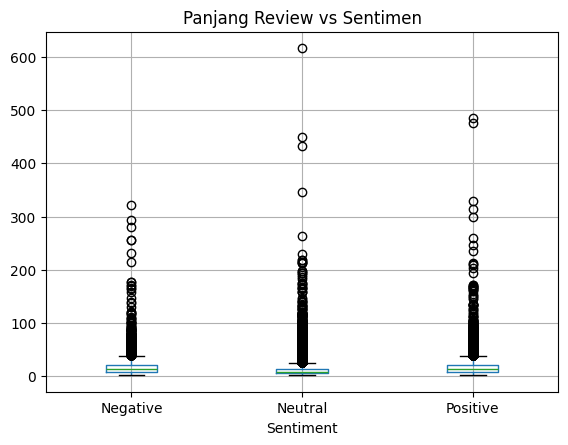

In [25]:
df.boxplot(column='text_length', by='Sentiment')
plt.title('Panjang Review vs Sentimen')
plt.suptitle('')
plt.show()

In [26]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

chars = get_unique_chars(df['Comment'])

chars

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\x80',
 '\x81',
 '\x82',
 '\x83',
 '\x84',
 '\x86',
 '\x87',
 '\x88',
 '\x89',
 '\x8a',
 '\x8b',
 '\x8c',
 '\x8d',
 '\x8e',
 '\x8f',
 '\x90',
 '\x91',
 '\x92',
 '\x93',
 '\x94',
 '\x95',
 '\x96',
 '\x97',
 '\x98',
 '\x99',
 '\x9a',
 '\x9b',
 '\x9c',
 '\x9d',
 '\x9e',
 '\x9f',
 '¡',
 '¢',
 '£',
 '¤',
 '¥',
 '¦',
 '§',
 '¨',
 '©',
 'ª',
 '«',
 '¬',
 '\xad',
 '®',
 '¯',
 '°',
 '±',
 '²',
 '³',
 '´',
 'µ',
 '¶',
 '·',
 '¸',
 '¹',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 '¿',
 '×',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'õ',
 'ö',
 '÷',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ā',
 'ă',
 'ą',
 'ć',
 'č',
 'đ',
 'ę',
 'ě',
 'ğ',
 'ĩ',
 'ı',
 'ł',
 'ń',
 'ō',
 'ő',
 'œ',
 'ř',
 'ś',
 'ş',
 'š',
 'ũ',
 'ů',
 'ű',
 'ż',
 'ž',
 'ơ',
 'ƪ',
 'ư',
 'ș',
 'ț',
 'ə'

Sekali lagi, kita menemukan kata alfabet non inggris yang dimana akan kita tangani ke depannya

Selanjutnya, kita akan menangani data yang memiliki emoji terlebih dahulu

In [27]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 43.4 MB/s eta 0:00:00


In [28]:
import emoji
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

In [29]:
df_with_emoji = df[df['Comment'].apply(contains_emoji)]
print(len(df_with_emoji))

518


In [30]:
df_with_emoji.head(10)

,ID,Comment,Sentiment,text_length,is_spam
47118,47895,💩👎💩👎💩👎💩 👻☠️ impossible delete list sub lists tabs ☠️👻 regret upgrade 👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎💩👎,Negative,12,False
47434,48211,reminder feature working 🥱,Negative,4,False
47480,48257,regular user appthis app needs update like calendar based listing method people go date list taskanother problem many color list annoying dont like colors select one color every task list all🙂🙂🙂,Neutral,31,False
47576,48353,literally blessed know todoist♥️,Positive,4,False
47587,48364,app good past anymore stopped sync many bugs creeped due maintenance update since per details app page last update jun still first thing comes results search habit 😲 guess google stop advertising app managed since years,Negative,36,False
47638,48415,wasnt sure begin user friendly frustrating take chance anyway pay premium sync calendars wasnt really reason pay premium except small waste money use 😒,Negative,24,False
47902,48679,please extend beta program seats 😊,Positive,6,False
48038,48815,app let create widget despite fact logged ☹️,Neutral,8,False
48123,48900,using appa past months seems good methis apps helps organising stuffi love it☺,Positive,13,False
48164,48941,hey downloaded app paid premium saw memo box said unlocked premium id get coins yet see app balance coins asking pay receive coins gives 🤔,Neutral,25,False


In [31]:
df['Comment'] = df['Comment'].apply(lambda x: emoji.demojize(x))

In [32]:
df[df['Comment'].str.contains(":")]['Comment']

,Comment
47118,:pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo: :ghost::skull_and_crossbones: impossible delete list sub lists tabs :skull_and_crossbones::ghost: regret upgrade :thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down::pile_of_poo::thumbs_down:
47434,reminder feature working :yawning_face:
47480,regular user appthis app needs update like calendar based listing method people go date list taskanother problem many color list annoying dont like colors select one color every task list all:slightly_smiling_face::slightly_smiling_face::slightly_smiling_face:
47576,literally blessed know todoist:heart_suit:
47587,app good past anymore stopped sync many bugs creeped due maintenance update since per details app page last update jun still first thing comes results search habit :astonished_face: guess google stop advertising app managed since years
...,...
237048,modi interacted citizens new delhi everyone took vow work like chowkidar vigilant active path dutyà¥à¤¿à¤¾ à¤¦à¤:registered:à¤¦à¤¾ à¤ªà¤¹à¤°à¥à¤¾
237752,might get dã:copyright:jã watching interview reminisce interview modi asked sir get much energy
238942,ravi listening modi â speech today must tell different note really admire way speak amazing orator pointed impassioned wan describe skill urs à¤¿à¥à¤:registered:à¤¯à¤à¤¾à¥ à¤à¤¿ à¥à¥à¤¯à¤à¤¨à¤
239041,à¤¿à¥ à¥à¥à¤ à¤¼à¥ à¥ à¥à¤°à¤à¤:registered:à¤¾à¤¨à¤¤à¤ªà¤°à¤¹à¥à¤ congress concerned malai bhalai arunachal via namo app


In [33]:
df_with_emoji = df[df['Comment'].apply(contains_emoji)]
print(len(df_with_emoji))

0


Untuk kasus emoji, emoji dipertahankan dengan mengubahnya menjadi teks karena emoji bisa memberikan sinyal tambahan untuk analisis sentimen walau hanya sedikit karena row yang ada emoji sangat sedikit. Lalu nantinya : akan diclean menjadi spasi

In [34]:
model_name = "papluca/xlm-roberta-base-language-detection"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

id2label = model.config.id2label


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [35]:
def detect_lang_xlm(text):
    if not isinstance(text, str) or text.strip() == "":
        return "unknown", 0.0

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)

    conf, pred = torch.max(probs, dim=-1)
    lang = id2label[pred.item()]

    return lang, conf.item()


In [36]:
df[['lang_xlm', 'lang_prob']] = df['Comment'].apply(
    lambda x: pd.Series(detect_lang_xlm(x))
)

In [37]:
df['lang_xlm'].value_counts()

,count
lang_xlm,
en,121508
sw,93890
hi,13370
ur,4151
it,1861
pt,1846
nl,1262
tr,714
es,596


In [38]:
df[df['lang_xlm'] == 'sw'].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob
25,25,dan man saving day riley needs give theme like brian electrician,Positive,11,False,sw,0.379726
36,36,epozhum safety first priority goggles,Positive,5,False,sw,0.340124
78,78,havent laughed like years oh gosh arun youve nailed one wendi,Positive,11,False,sw,0.322358
161,161,boat pod looks lot like saiyan space capsule… need one lol,Positive,11,False,sw,0.592634
171,171,stuff mentioned dji mic amazing recording device,Positive,7,False,sw,0.522589


In [39]:
df[df['lang_xlm'] == 'pt'].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob
66,66,john oliver deserves oscar dolphins love monologue,Positive,7,False,pt,0.622056
491,491,charlie republican democrat independent conservative liberal socialist,Neutral,7,False,pt,0.699924
602,603,amanda crosta enaltecendo globo colocando globo como melhor mundo ela não cansa de passar vergonha faça perguntas sobre governo,Neutral,19,False,pt,0.995865
603,604,que bom que falhou microfone da amanda deveria deixar mudo seria um bom serviço para meus ouvidos,Neutral,17,False,pt,0.995908
604,605,presidente em mais um podcast vai estar ironberg podcast renato karine junto com doutor paulo muzy sexta feira,Neutral,18,False,pt,0.995618


Ternyata model bert masih salah memprediksi jenis bahasa dengan tepat. Setelah dilihat lagi ternyata akibat beberapa teks :
- Terlalu pendek
- Mengandung slang
- Grammar error

Setelah inspeksi dari beberapa kelas, bahasa yang mayoritas tetaplah inggris (en + sw + ur) (karena ada campur aduk bahasa). Jadi akan dicoba untuk menghilangkan yang non inggris

In [40]:
lang_counts = df['lang_xlm'].value_counts()

langs_to_keep = lang_counts[lang_counts >= 2000].index

df_new = df[df['lang_xlm'].isin(langs_to_keep)]

Pertama - tama, kita akan membuang kelas dataset yang languagenya sedikit dulu

In [41]:
df_new['lang_xlm'].value_counts()

,count
lang_xlm,
en,121508
sw,93890
hi,13370
ur,4151


In [42]:
df_new[df_new['lang_xlm'] == 'sw'].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob
25,25,dan man saving day riley needs give theme like brian electrician,Positive,11,False,sw,0.379726
36,36,epozhum safety first priority goggles,Positive,5,False,sw,0.340124
78,78,havent laughed like years oh gosh arun youve nailed one wendi,Positive,11,False,sw,0.322358
161,161,boat pod looks lot like saiyan space capsule… need one lol,Positive,11,False,sw,0.592634
171,171,stuff mentioned dji mic amazing recording device,Positive,7,False,sw,0.522589


In [43]:
df_new[df_new['lang_xlm'] == 'ur'].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob
83,83,edge cloud hydrogen fuel cell star link ai gpt lithium ion battery block chain quantum computing,Neutral,16,False,ur,0.807448
246,246,next week battle tech hank vs golden retriever,Neutral,8,False,ur,0.203266
527,527,even though trump barely read putin sure read every page trump handed,Neutral,12,False,ur,0.333318
749,751,oras livestream augt replay,Neutral,4,False,ur,0.487119
751,753,dz dobol b,Neutral,3,False,ur,0.878441


In [44]:
df_new[df_new['lang_xlm'] == 'hi'].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob
32,32,liquid nitrogen ഇതുവരെ തീർന്നില്ലേ മച്ചാനെ,Neutral,5,False,hi,0.456485
35,35,കേരളത്തിൽ ആദ്യമായി പെട്രോളിനെ എയ്സ് ആക്കിയ മച്ചാന്മാർ,Neutral,6,False,hi,0.848611
38,38,തന്നെ തളർത്താൻ നോക്കിയവർ പോലും അവന്റെ ഉയർച്ചയിൽ പകച്ച് നിന്നു പോയി കഷ്ടപ്പാടും അദ്ധ്വാനവുംകൊണ്ട് പേർ പടുത്തുയർത്തിയ ചാനൽ tech,Neutral,15,False,hi,0.730552
39,39,എത്ര എടുത്താലും തീരാത്ത liquid nitrogen,Neutral,5,False,hi,0.494343
652,653,पत्रकार को बहुत जल्दी पता चलता है कि कहाँ है जब झारखंड में आदिवासी मूल वासी अपनी हक अधिकार के लिए और स्थानीय नीति को लेकर आंदोलन कर रहे है ये सभी बातें मिडिया के कानों में नहीं आती अब झारखंड सांत है तो अशांति फैलाना बंद करे जय झारखंड जोहार झारखंड,Neutral,52,False,hi,0.995559


In [45]:
df_new = df_new[df_new['lang_xlm'] != 'hi']

Bahasa kelas hi dihapus karena setelah inspeksi sebagian besar memang berbahasa hindu

Lalu bahasa kelas ur dan sw dipertahankan karena mayoritas hanya karena grammarnya jelek

In [46]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

chars = get_unique_chars(df_new['Comment'])

chars

[' ',
 '-',
 ':',
 'C',
 'K',
 'M',
 'N',
 'O',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\x80',
 '\x81',
 '\x82',
 '\x83',
 '\x84',
 '\x86',
 '\x87',
 '\x88',
 '\x89',
 '\x8a',
 '\x8b',
 '\x8c',
 '\x8d',
 '\x8e',
 '\x8f',
 '\x90',
 '\x91',
 '\x92',
 '\x93',
 '\x94',
 '\x95',
 '\x96',
 '\x97',
 '\x98',
 '\x99',
 '\x9a',
 '\x9b',
 '\x9c',
 '\x9d',
 '\x9e',
 '\x9f',
 '¡',
 '¢',
 '£',
 '¤',
 '¥',
 '¦',
 '§',
 '¨',
 'ª',
 '«',
 '¬',
 '\xad',
 '¯',
 '°',
 '±',
 '²',
 '³',
 '´',
 'µ',
 '¶',
 '·',
 '¸',
 '¹',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 '¿',
 '×',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'ï',
 'ð',
 'ñ',
 'ó',
 'ô',
 'ö',
 '÷',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ā',
 'ō',
 'ş',
 'ż',
 'ž',
 'ƪ',
 'ɠ',
 'ɡ',
 'ɾ',
 'ʃ',
 '̀',
 '́',
 '̇',
 'ͳ',
 'α',
 'β',
 'γ',
 'δ',
 'ζ',
 'η',
 'θ',
 'λ',
 'μ',
 'ν',
 'ξ',
 'π',
 'σ',
 'τ',
 'φ',
 'χ'

In [47]:
char_to_check = [ 'à','á','â','ã','ä','å', 'è','é','ê','ë','ì','í','ï','ð','ñ','ó','ô','õ','ö','÷','ø','ù','ú','û','ü','ý']

def has_weird_char(text):
    return any(c in char_to_check for c in text)

df_new['has_weird_char'] = df_new['Comment'].apply(has_weird_char)

print(df_new.groupby('lang_xlm')['has_weird_char'].sum())

lang_xlm
en     5311
sw    11521
ur     1524
Name: has_weird_char, dtype: int64


In [48]:
df_new[df_new['has_weird_char']].head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob,has_weird_char
186,186,yup amazing though market changes brands country germany entirely different line knockoff chinese brands ultimately look alike goes australian american market kinda stoked see though sort dashcams actually used within south korea japan anybody could give hint mean surely must great dashcams right japan leading technology country severe amount car enthusiasts well south korea well main birth place technology centre fab well least good portion mind bought one due recommendation friend mine problem quality related gsensor broke long bought thing started using kinda unfortunate creates issue thing constantly making emergency recordings mode cant disable screen flashing night drives youll really get beamed faze think someone put flashlight head nope f dashcam improve video quality eg experincing intense sun glare usually caused using ndfilter find way mount usually full filter clamping solutions youll overshoot filter anyhow didnt yet find nessecary big german dashcam clip compilation maker recommend one dashcam review videos half year ago name channel eure videos fahrnünftig german amazon thieye american market jansite nexigo australian nz market volway,Positive,169,False,en,0.848525,True
235,235,settle lemon great cheesecake chocolate soufflé circle chant restauranteur three times mirror wolfgang puck appear behind,Neutral,16,False,en,0.420468,True
1079,1085,think we’ve reached point devs need come better idea aí decades able make games look better lot games actually worse gameplay wise stale ideas dumbed mechanics older games,Negative,28,False,en,0.825750,True
1448,1455,jarmila kratochvílová holds current world record set july munich definitely missing video record longest ever official world record womens athletics also missing jan železný current world record holder javelin throw jena may,Neutral,32,False,sw,0.865517,True
1502,1509,missed manè nobody wants admitted sorry,Negative,6,False,en,0.967027,True


In [49]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 17.0 MB/s eta 0:00:00


Ternyata terdapat unicode text, tinggal lakukan mapping biasa ke alfabet inggris

Untuk teks lainnya akan dinormalisasi sehingga teks yang masih tercampur akan dibuang

In [50]:
from unidecode import unidecode

def normalize_text(text):
    text = unicodedata.normalize("NFKC", text)

    text = unidecode(text)

    text = text.lower().strip()

    text = re.sub(r"[\x00-\x1f\x7f-\x9f\u202c\u2066\u2069\uf0d8]", " ", text)

    text = text.replace("\xad", "")

    text = text.replace("‘", "'").replace("’", "'").replace("‚", "'").replace(":"," ")

    text = re.sub(r"[^a-zà-ÿ\s?.!,\"']", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text


df_new['Comment'] = df_new['Comment'].apply(normalize_text)


In [51]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

chars = get_unique_chars(df_new['Comment'])

chars

[' ',
 '!',
 '"',
 "'",
 ',',
 '.',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [52]:
df_new['text_length'] = df_new['Comment'].apply(lambda x : len(x.split()))

In [53]:
df_new = df_new[df_new['text_length'] > 0]

Lalu dibuang teks yang hanya berisi kata kata non alfabet inggris

In [54]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219549 entries, 0 to 241144
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              219549 non-null  int64  
 1   Comment         219549 non-null  object 
 2   Sentiment       219549 non-null  object 
 3   text_length     219549 non-null  int64  
 4   is_spam         219549 non-null  bool   
 5   lang_xlm        219549 non-null  object 
 6   lang_prob       219549 non-null  float64
 7   has_weird_char  219549 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(3)
memory usage: 12.1+ MB


In [55]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

chars = get_unique_chars(df_new['Comment'])

chars

[' ',
 '!',
 '"',
 "'",
 ',',
 '.',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [56]:
df_new.head()

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob,has_weird_char
0,0,lets forget apple pay required brand new iphone order use significant portion apples user base wasnt able use even wanted successive iphone incorporated technology older iphones replaced number people could use technology increased,Neutral,33,False,en,0.985656,False
1,1,nz retailers don't even contactless credit card machines like paywave support apple pay don't like high fees come,Negative,18,False,en,0.967953,False
2,2,forever acknowledge channel help lessons ideas explanations quite helpful youll sit comfort monitor account growth,Positive,15,False,en,0.905616,False
3,3,whenever go place doesn't take apple pay doesn't happen often it's drag 'contactless covid' habits getting apple card i've gotten used apple pay get seriously annoyed store doesn't take feels like shock it's crazy quickly took shopping routine i've officially brainwashed apple feels inconvenient even carry physical card pocket,Negative,49,False,en,0.990807,False
4,4,apple pay convenient secure easy use used korean japanese airports need physical credit cards,Positive,14,False,en,0.987488,False


In [57]:
words = df_new['Comment'].str.split().explode()
num_unique_words = words.nunique()

print(num_unique_words)

137077


Ada terdapat 137077 kata unik

Data cleaning telah selesai, selanjutnya model preprocessing

# Model Preprocessing

In [58]:
df = df_new

In [59]:
df.head(5)

,ID,Comment,Sentiment,text_length,is_spam,lang_xlm,lang_prob,has_weird_char
0,0,lets forget apple pay required brand new iphone order use significant portion apples user base wasnt able use even wanted successive iphone incorporated technology older iphones replaced number people could use technology increased,Neutral,33,False,en,0.985656,False
1,1,nz retailers don't even contactless credit card machines like paywave support apple pay don't like high fees come,Negative,18,False,en,0.967953,False
2,2,forever acknowledge channel help lessons ideas explanations quite helpful youll sit comfort monitor account growth,Positive,15,False,en,0.905616,False
3,3,whenever go place doesn't take apple pay doesn't happen often it's drag 'contactless covid' habits getting apple card i've gotten used apple pay get seriously annoyed store doesn't take feels like shock it's crazy quickly took shopping routine i've officially brainwashed apple feels inconvenient even carry physical card pocket,Negative,49,False,en,0.990807,False
4,4,apple pay convenient secure easy use used korean japanese airports need physical credit cards,Positive,14,False,en,0.987488,False


In [60]:
all_words = ' '.join(df['Comment'].sample(5000)).split()
Counter(all_words).most_common(20)

[('modi', 3024),
 ('india', 594),
 ('like', 418),
 ('people', 305),
 ('one', 301),
 ('bjp', 290),
 ('time', 269),
 ('dont', 259),
 ('congress', 253),
 ('get', 250),
 ('narendra', 234),
 ('a', 209),
 ('good', 202),
 ('would', 202),
 ('years', 200),
 ('govt', 192),
 ('vote', 186),
 ('know', 183),
 ('make', 180),
 ('work', 176)]

In [61]:
X = df['Comment']
y = df['Sentiment']

In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [63]:
X_train.shape, X_val.shape, X_test.shape

((153684,), (32932,), (32933,))

In [64]:
tokenizer = Tokenizer(num_words=137077, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=128
)

X_val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=128
)

X_test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=128
)


In [65]:
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

y_train = y_train.map(label_map)
y_val   = y_val.map(label_map)
y_test  = y_test.map(label_map)

In [66]:
y_train,y_val,y_test

(217814    2
 82116     2
 201455    2
 197700    2
 102908    2
          ..
 59806     1
 74721     2
 182552    1
 90913     1
 185393    0
 Name: Sentiment, Length: 153684, dtype: int64,
 116486    1
 187576    2
 89256     2
 67268     1
 143044    1
          ..
 158740    2
 155495    0
 96366     2
 23808     0
 64114     2
 Name: Sentiment, Length: 32932, dtype: int64,
 78366     1
 90511     2
 95034     1
 113605    0
 164374    0
          ..
 34789     1
 108607    2
 43469     0
 170410    1
 186828    1
 Name: Sentiment, Length: 32933, dtype: int64)

In [67]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train.to_numpy()
)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

{np.int64(0): np.float64(1.416821085820173), np.int64(1): np.float64(1.022474152728434), np.int64(2): np.float64(0.7597775305895439)}


# Model RNN

In [68]:
vocab_size = 137077
max_features = 20000
embedding_dim = 128
maxlen = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),

    Bidirectional(GRU(1024, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(GRU(512)),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [69]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, maxlen))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 128)       │    17,545,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 2048)      │     7,090,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1024)           │     7,870,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,509,571 (124.01 MB)

 Trainable params: 32,509,571 (124.01 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=15,
    batch_size=64,
    class_weight=class_weights_dict
)

Epoch 1/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 762s 312ms/step - accuracy: 0.7017 - loss: 0.7110 - val_accuracy: 0.8236 - val_loss: 0.4758
Epoch 2/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 745s 310ms/step - accuracy: 0.8738 - loss: 0.3580 - val_accuracy: 0.8239 - val_loss: 0.4900
Epoch 3/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 730s 304ms/step - accuracy: 0.9088 - loss: 0.2725 - val_accuracy: 0.8273 - val_loss: 0.5603
Epoch 4/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 724s 301ms/step - accuracy: 0.9464 - loss: 0.1667 - val_accuracy: 0.8316 - val_loss: 0.6182
Epoch 5/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 722s 300ms/step - accuracy: 0.9618 - loss: 0.1154 - val_accuracy: 0.8211 - val_loss: 0.6894
Epoch 6/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 721s 300ms/step - accuracy: 0.9713 - loss: 0.0858 - val_accuracy: 0.8270 - val_loss: 0.8773
Epoch 7/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 718s 299ms/step - accuracy: 0.9782 - loss: 0.0666 - val_accuracy: 0.8182 - val_loss: 0.8579
Epoch 8/15
2402/2402 ━━━━━━━━━━━━━━━━━━━━ 718s 299ms/step - ac

# Model Testing & Evaluation

In [71]:
loss, acc = model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - accuracy: 0.8231 - loss: 1.2122
Test Loss: 1.2016
Test Accuracy: 0.8219


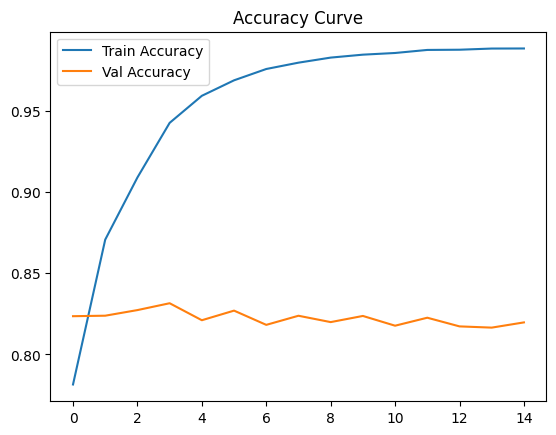

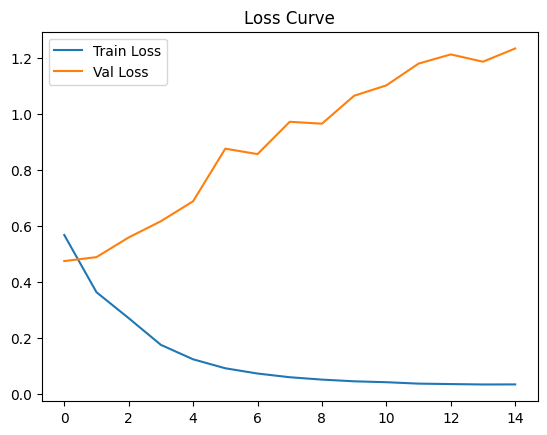

In [79]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


Accuracy Curve :
Saat Train, accuracy naik dari ~0.75 - ~0.95. Lalu saat validation, accuracy berada di ~0.83 dan stagnan di rentang tersebut

Interpretasi : Model dapat dibilang hanya menghafal data trainning. Hal ini terlihat dari accuracy validasi yang tidak naik-naik


Loss Curve :
Saat train, loss turun terus menerus naik dari 0.5 - 1.0

Interpretasi:Model tidak dapat melakukan generalisasi pada data validasi yang menunjukan terjadinya overfitting parah dimana gap antara validasi dan trainning makin membesar tiap epochnya


In [73]:
y_pred_prob = model.predict(X_test_seq)

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 62s 60ms/step


In [77]:
y_pred = np.argmax(y_pred_prob, axis=1)

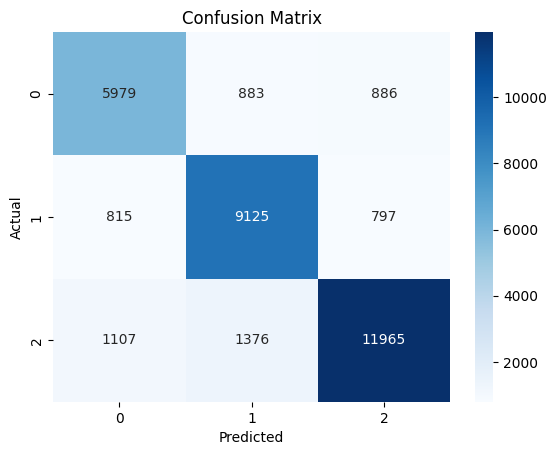

In [78]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
print(classification_report(
    y_test, y_pred,
    target_names=['Negative', 'Neutral','Positive']
))

              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76      7748
     Neutral       0.80      0.85      0.83     10737
    Positive       0.88      0.83      0.85     14448

    accuracy                           0.82     32933
   macro avg       0.81      0.82      0.81     32933
weighted avg       0.82      0.82      0.82     32933



1. Interpretasi per kelas

a. Sentimen Negatif

Precision: 0.76
Recall: 0.77
F1: 0.76
Support (test): 7,748

Interpretasi:

- Precision yang lebih rendah (0.76) menunjukkan bahwa model cenderung kurang berhati-hati dalam memberi label negatif, sehingga beberapa teks yang sebenarnya bukan negatif tetap diklasifikasikan sebagai negatif (false positive)

- Recall sebesar 0.77 menunjukkan bahwa model cukup sensitif dalam menangkap pola sentimen negatif, sehingga sebagian besar data negatif berhasil terdeteksi meskipun masih terdapat beberapa kasus yang terlewat

- Nilai F1-score sebesar 0.76 menunjukkan keseimbangan yang cukup baik antara precision dan recall pada kelas negatif. Nilai ini dalam rentang yang masuk akal karena nilai ini juga dipenagaruhi oleh karakteristik data dimana kelas negatif memiliki jumlah paling sedikti dari sentimen lainnya. Lalu, perlu diingat juga kalau bahasa negatif biasanya lebih implisit (contohnya sarkasme dan keluhan halus)

b. Sentimen Netral

Precision: 0.80
Recall: 0.85
F1: 0.83
Support (test): 10,737

Interpretasi:

- Precision sebesar 0.80 ini menunjukkan bahwa model cukup akurat dalam memprediksi sentimen netral, sehingga sebagian besar prediksi netral yang dihasilkan sudah tepat dan tingkat false positive relatif rendah

- Recall yang cukup tinggi (0.85) menunjukkan bahwa model mampu menangkap sebagian besar data netral, sehingga kasus sentimen netral yang terlewat relatif sedikit

- Nilai F1-score sebesar 0.83 menunjukkan keseimbangan yang cukup baik antara Precision dan Recall model dalam mengenali sentimen netral. Hal ini berarti model memiliki pemahaman yang baik terhadap boundary kelas netral, terutama dalam membedakannya dengan sentimen kelas positif dan negatif

c. Sentimen Positif

Precision: 0.88
Recall: 0.83
F1: 0.85
Support (test): 14,448

Interpretasi:


- Precision yang tinggi (0.88) menunjukkan bahwa model sangat berhati-hati dalam memberikan label positif, sehingga prediksi sentimen positif yang dihasilkan jarang salah dan false positive pada kelas ini lebih rendah

- Recall yang tinggi (0.83) menunjukkan bahwa model memiliki sensitivitas yang baik dalam mendeteksi sentimen positif, sehingga sebagian besar data positif berhasil terdeteksi dan hanya sedikit kasus yang terlewat

- Nilai F1-score sebesar 0.85 menunjukkan keseimbangan yang cukup baik antara precision dan recall pada kelas positif dimana nilai ini merupakan nilai tertinggi dari kelas lainnya. Hal ini bisa terjadi karena juga terdapat dominasi kelas sentimen positif yang dimana sedikit lebih besar dibandingkan kedua kelas sentimen lainnya. Selain itu, perlu diingat kalau bahasa sentimen positif cenderung lebih eksplisit (contohnya kata "happy" atau "good")

2. Gambaran umum performa model

Accuracy = 0.82
Accuracy 82% ini berarti dari 100 prediksi hanya 82 prediksi yang benar. Akurasi ini cukup baik untuk dataset real world yang cenderung memiliki noise tinggi

Macro avg F1 = 0.81
Macro F1 menandakan apakah model cukup adil prediksinya untuk semua kelas dengan juga mempertimbangkan keseimbangan antara precision dan recall. Disini, Macro F1 nya cukup baik, yaitu sekitar 0.81 yang menandakan model  memiliki performa yang cukup seimbang dan tidak bias pada kelas tertentu, sehingga dapat dibilang kalau model cukup adil dalam memprediksi seluruh jenis sentimen

Weighted Average F1 = 0.82
Weighted Average F1 menandakan apakah model memiliki performa yang baik dengan juga mempertimbangkan keseimbangan antara precision dan recall. pada distribusi data yang realistis. Weighted Averagenya cukup baik, yaitu sekitar 0.82 yang menandakan model bekerja cukup baik pada distribusi data real world yang memiliki distribusi sentimen tidak seimbang

Secara umum, model tidak bias pada kelas yang lebih mayoritas dan dapat belajar pada setiap kelas cukup baik



# Model BERT (Pytorch)

Disini akan dipakai bert uncased karena teks sudah lower dan juga hanya ada bahasa inggris

Selain itu, kita akan memakai pytorch untuk bert karena bert lebih disupport di pytorch dibandingkan keras

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import BertTokenizer,TFBertForSequenceClassification

In [ ]:
from sklearn.model_selection import train_test_split

X = df['Comment']

In [ ]:
labels = df['Sentiment'].map({
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}).values


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((153684,), (32932,), (32933,))

In [ ]:
classes = np.unique(y_train)

class_weights = compute_class_weight("balanced", classes=classes, y=y_train)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)

Class weights: tensor([1.4168, 1.0225, 0.7598], device='cuda:0')


In [ ]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

val_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = MyDataset(train_encodings, y_train)
val_dataset = MyDataset(val_encodings, y_val)
test_dataset = MyDataset(test_encodings,y_test)


In [ ]:
from transformers import BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for param in model.bert.encoder.layer[:11].parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[11:].parameters():
    param.requires_grad = True


In [ ]:
print(model)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # tambahkan **kwargs
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import TrainerCallback

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
import evaluate

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    gradient_accumulation_steps=2,
    fp16=True,
    report_to=[]
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy
1,0.506800,0.472450,0.821116
2,0.412000,0.434803,0.848536
3,0.346400,0.431965,0.855338
4,0.289900,0.444949,0.858314
5,0.255000,0.490366,0.861806
6,0.216500,0.495438,0.863658
7,0.188100,0.540275,0.861229
8,0.159400,0.572024,0.862687
9,0.138100,0.696989,0.865663
10,0.122600,0.721793,0.866209


/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommende

Epoch,Training Loss,Validation Loss,Accuracy
1,0.506800,0.472450,0.821116
2,0.412000,0.434803,0.848536
3,0.346400,0.431965,0.855338
4,0.289900,0.444949,0.858314
5,0.255000,0.490366,0.861806
6,0.216500,0.495438,0.863658
7,0.188100,0.540275,0.861229
8,0.159400,0.572024,0.862687
9,0.138100,0.696989,0.865663
10,0.122600,0.721793,0.866209


/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


TrainOutput(global_step=72045, training_loss=0.21172162665277708, metrics={'train_runtime': 11642.0252, 'train_samples_per_second': 198.012, 'train_steps_per_second': 6.188, 'total_flos': 1.5163620933791232e+17, 'train_loss': 0.21172162665277708, 'epoch': 15.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(f"Test Loss: {results['eval_loss']:.4f}")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")


/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Test Loss: 0.4323
Test Accuracy: 0.8573


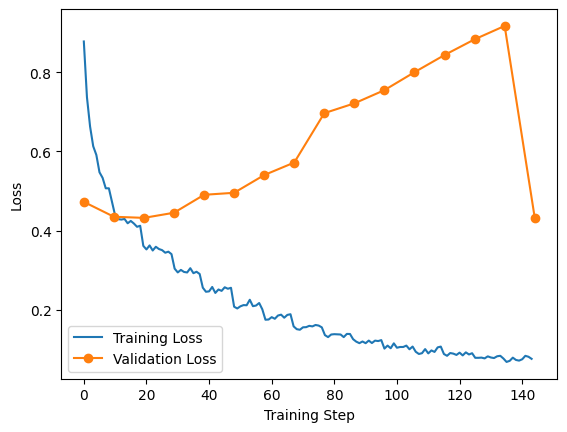

In [ ]:
log_history = trainer.state.log_history

train_loss = [
    x["loss"] for x in log_history
    if "loss" in x and "eval_loss" not in x
]

val_loss = [
    x["eval_loss"] for x in log_history
    if "eval_loss" in x
]


plt.plot(train_loss, label="Training Loss")
plt.plot(
    np.linspace(0, len(train_loss), len(val_loss)),
    val_loss,
    marker="o",
    label="Validation Loss"
)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.show()


Loss Curve :
Saat train, loss menurun secara terus menerus dari sekitar ~0.9 hingga ~0.1, yang menunjukkan bahwa model terus belajar dengan baik pada data training.
Akan tetapi, pada tahap validasi, loss awalannya sedikit menurun hingga sekitar ~0.43, namun setelah itu cenderung naik sampai ~0.9

Interpretasi: Model awalnya belajar dengan baik pada data trainning, tetapi lagi-lagi loss validasi yang tidak turun menunjukan terjadinya overfitting

Catatan : Validation loss yang tiba tiba turun itu karena load_best_model_at_end=True bukan karena val loss tiba tiba turun, tetapi karena trainer meload best model sebelumnya

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids

/tmp/ipython-input-322551133.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-322551133.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
y_pred_prob = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = labels


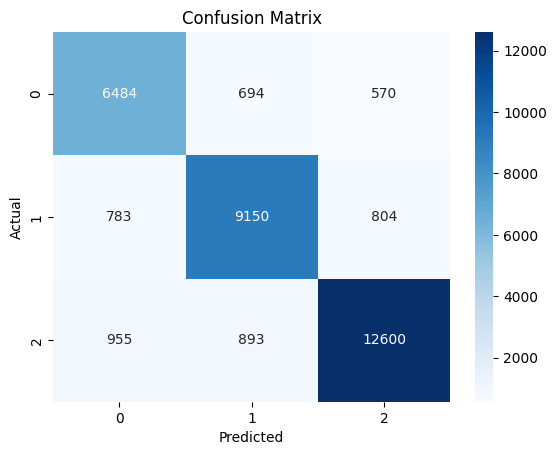

              precision    recall  f1-score   support

    Negative       0.79      0.84      0.81      7748
     Neutral       0.85      0.85      0.85     10737
    Positive       0.90      0.87      0.89     14448

    accuracy                           0.86     32933
   macro avg       0.85      0.85      0.85     32933
weighted avg       0.86      0.86      0.86     32933



In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(
    y_true, y_pred,
    target_names=['Negative','Neutral','Positive']
))


1. Interpretasi per kelas

a. Sentimen Negatif

Precision: 0.79 Recall: 0.84 F1-score: 0.81 Support (test): 7,748

Interpretasi:
- Precision yang lebih rendah (0.79) menunjukkan bahwa model kurang berhati-hati dalam memberi label negatif, sehingga beberapa teks yang sebenarnya bukan negatif tetap diklasifikasikan sebagai negatif (false positive)

- Recall sebesar 0.84 menunjukkan bahwa model memiliki tingkat sensitivitas yang baik dalam menangkap pola sentimen negatif, sehingga sebagian besar data negatif berhasil terdeteksi meskipun masih terdapat sedikit kasus yang terlewat

- Nilai F1-score sebesar 0.81 menunjukkan keseimbangan yang baik antara precision dan recall pada kelas negatif. Nilai ini dalam rentang yang masuk akal karena nilai ini juga dipenagaruhi oleh karakteristik data dimana kelas negatif memiliki jumlah paling sedikti dari sentimen lainnya. Lalu, perlu diingat juga kalau bahasa negatif biasanya lebih implisit (contohnya sarkasme dan keluhan halus)


b. Sentimen Netral

Precision: 0.85 Recall: 0.85 F1-score: 0.85 Support (test): 10,737

Interpretasi:

- Precision sebesar 0.85 ini menunjukkan bahwa model lumayan akurat dalam memprediksi sentimen netral, sehingga banyak prediksi netral yang dihasilkan sudah tepat dan tingkat false positive relatif rendah

- Recall sebesar 0.85 menunjukkan bahwa model mampu menangkap mayoritas data netral, sehingga kasus sentimen netral yang terlewat hanya sedikit

- Nilai F1-score sebesar 0.85 menunjukkan keseimbangan yang tinggi antara Precision dan Recall model dalam mengenali sentimen netral. Hal ini berarti model memiliki pemahaman yang baik terhadap boundary kelas netral, terutama dalam membedakannya dengan sentimen kelas positif dan negatif

c. Sentimen Positif

Precision: 0.90 Recall: 0.87 F1-score: 0.89 Support (test): 14,448

Interpretasi:

- Precision yang sangat tinggi (0.90) menunjukkan bahwa model sangat berhati-hati dalam memberikan label positif, sehingga prediksi sentimen positif yang dihasilkan sangat jarang salah dan false positive pada kelas ini jauh lebih rendah

- Recall yang tinggi (0.87) menunjukkan bahwa model memiliki sensitivitas yang tinggi dalam mendeteksi sentimen positif, sehingga sebagian besar data positif berhasil terdeteksi dan hanya sedikit kasus yang terlewat

- Nilai F1-score sebesar 0.89 menunjukkan keseimbangan yang sangat baik antara precision dan recall pada kelas positif dimana nilai ini merupakan nilai tertinggi dari kelas lainnya. Hal ini bisa terjadi karena juga terdapat dominasi kelas sentimen positif (~100k) yang dimana sedikit lebih besar dibandingkan kedua kelas sentimen lainnya. Selain itu, perlu diingat kalau bahasa sentimen positif cenderung lebih eksplisit (contohnya kata "happy" atau "good")

2. Gambaran umum performa model

Accuracy = 0.86
Accuracy 86% ini berarti dari 100 data train, sekitar 86 data berhasil diprediksi dengan benar. Akurasi ini lumayan tinggi, khususnya untuk sentiment analysis pada data teks yang cukup noisy

Macro Average F1 = 0.85
Macro F1 menandakan apakah model cukup adil prediksinya untuk semua kelas dengan juga mempertimbangkan keseimbangan antara precision dan recall. Nilai 0.85 menunjukkan bahwa model memiliki performa yang cukup seimbang dalam memprediksi seluruh kelas sentimen dan tidak terlalu bias pada kelas tertentu, sehingga dapat dibilang model adil dalam memprediksi seluruh jenis sentimen

Weighted Average F1 = 0.86
Weighted F1 menandakan apakah model memiliki performa yang baik pada distribusi data yang realistis dengan juga mempertimbangkan keseimbangan antara precision dan recall. Nilai 0.86 menandakan bahwa model berjalan sangat baik pada distribusi data real-world, khususnya dengan dominasi kelas positif

Secara umum, model BERT menunjukkan performa yang kuat dan stabil, mampu belajar dengan baik pada setiap kelas sentimen, serta tidak terlalu bias terhadap kelas mayoritas.

# Perbandingan Kedua Model

Perbandingan antara Model RNN dari scratch dan Pretrained model BERT :
- Secara keseluruhan, BERT menunjukkan performa yang lebih unggul dan stabil dibandingkan model RNN dari scratch. Hal ini terlihat dari perbedaan Accuracy (0.86 vs 0.82), Macro F1 (0.85 vs 0.81), dan Weighted F1 (0.86 vs 0.82)
- Pada semua kelas sentimen, BERT secara konsisten memiliki precision, recall, dan F1-score yang lebih tinggi dibandingkan RNN. Selain itu, hal ini juga menunjukkan bahwa BERT lebih efektif dalam memahami konteks kalimat dan hubungan antar kata, termasuk ekspresi sentimen yang bersifat implisit
- Dari sisi perilaku prediksi,BERT menunjukkan tingkat kehati-hatian dalalm memprediksi yang lebih tinggi, terutama pada kelas sentimen positif. Hal ini bisa dilihat dari precision 0.90 dibandingkan 0.88 pada RNN yang menandakan bahwa BERT memiliki keyakinannya lebih tinggi dan kesalahan prediksi lebih rendah

# Kesimpulan

- Model BERT menunjukkan performa yang lebih unggul dibandingkan model RNN dari scratch

Hal ini dapat dijelaskan bahwa BERT merupakan model pretrained yang telah dilatih pada teks berskala besar sehingga BERT memiliki pemahaman awal yang cukup baik terhadap struktur bahasa ataupun konteks kalimat. Hal ini membuat BERT jauh lebih efektif dalam menangani berbagai kompleksitas teks dibandingkan RNN yang sepenuhnya bergantung pada data trainning yang ada

- Model RNN dan Pretrained BERT menunjukkan performa yang cukup baik dalam dataset teks yang noisy

Perlu diingat bahwa pada eda, kita menemukan teks multibahasa yang masih kemungkinan saling bercampur, struktur bahasa Inggris yang tidak baku, serta distribusi kelas sentimen yang tidak seimbang. Meskipun pada kondisi tersebut, kedua model tetap menunjukan performa yang cukup baik dan berpotensi untuk digunakan pada deployment di dunia nyata. Perlu dicatat, data sangat mempengaruhi performa model. Jika model dilatih dalam dataset teks yang lebih bersih, model akan mendapatkan performa yang lebih tinggi lagi

- Pada analisis kurva loss dan accuracy sebelumnya, dapat terlihat bahwa kedua model terjadi overfitting

Pada RNN, Overfitting wajar terjadi karena parameter GRU yang cukup besar. Oleh karena itu, penurunan kompleksitas model seperti mengurangi jumlah layer dapat menjadi opsi untuk menghindari overfitting. Selain itu, vocab size yang terlalu besar juga membuat model harus juga menghafal kata-kata kesalahan penulisan yang juga membuat overfitting. Untuk BERT, overfitting dapat dihindari dengan melakukan pengaturan fine-tuning yang lebih tepat


Video : https://binusianorg-my.sharepoint.com/personal/glenn_laymando_binus_ac_id/_layouts/15/guestaccess.aspx?share=IgDq1Fbyms6nTqsmDiqpUXXLAYQlWNBJRN44-un2CZCtJ7A&e=v5E35v